In [1]:
import numpy as np
import glob, os, sys
import xarray as xr
import pandas as pd
from netCDF4 import Dataset
from scipy.ndimage import label, binary_dilation, binary_erosion, generate_binary_structure
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.signal import fftconvolve
from skimage import data, draw
from skimage.feature import masked_register_translation
from scipy import ndimage as ndi
import copy

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def offset_to_speed(x, y, time_lag, dx=.5, dy=.5):
    """ Return normalized speed assuming uniform grid.
    """
    mag_movement = np.sqrt((dx*x)**2 + (dy*y)**2)
    mag_dir = np.arctan2(x*dx, y*dy)*180/np.pi
    mag_movement_mps = np.array([mag_movement_i / (time_lag) * 1000.0 for mag_movement_i in mag_movement.T]).T
    return mag_movement, mag_dir, mag_movement_mps

def get_pixel_size_of_clouds(dataset, total_tracks, track_variable='pcptracknumber'):

    """ Calculate pixel size of each identified cloud in the file.
    Parameters:
    -----------
    dataset: Dataset
        netcdf Dataset
    track_variable: string
        variable that contains pixel level values.
    Returns:
    --------
    counts: array_like
        Pixel size of every cloud in file. Cloud 0 is stored at 0.
    """
    storm_sizes = np.zeros(total_tracks+1)

    track, counts = np.unique(dataset.variables[track_variable][:], return_counts=True)
    storm_sizes[track] = counts
    storm_sizes[0] = 0
    return storm_sizes

def label_perimeter(tracknumber, connectivity):
    """
    Labels the perimeter on a 2D map from cell tracknumbers.
    """

    # Generate a cross structure
    dilationstructure = generate_binary_structure(2, connectivity=connectivity)

    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)

    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the cell mask
        itn = tracknumber == ii
        # Erode the cell by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the cell number
        tracknumber_perim[iperim == 1] = ii

    return tracknumber_perim

In [3]:
# datadir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/'
# figdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/advection_demo/'
# datadir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/celltracking/20181015.0000_20190303.0000/'
datadir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/'
figdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/advection_demo/'
os.makedirs(figdir, exist_ok=True)

# date = '20190125'
# date = '20181205'
# date = '20181130'
date = '20181111'
# filelist = sorted(glob.glob(f'{datadir}/*20190125.*.nc'))
filelist = sorted(glob.glob(f'{datadir}/*{date}*nc'))
print(f'Found {len(filelist)} files.')
# test_file_idx = 47
# test_file_idx = 72
# test_file_idx = 79
test_file_idx = 20
filename_1 = filelist[test_file_idx]
filename_2 = filelist[test_file_idx+1]

print(f'Starting with file: {filename_1}, {filename_2}')

Found 96 files.
Starting with file: /global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/taranis_corcsapr2cfrppiqcM1_convmask.c1.20181111.050003.nc, /global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/taranis_corcsapr2cfrppiqcM1_convmask.c1.20181111.051503.nc


In [4]:
varname = 'dbz_comp'
# varname = 'comp_ref'
dset_1 = xr.open_dataset(filename_1)
reflectivity_1 = dset_1[varname].values

dset_2 = xr.open_dataset(filename_2)
reflectivity_2 = dset_2[varname].values

In [5]:
fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
figname = figdir + fignametimestr + '.png'
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/advection_demo/20181111_0500.png'

In [6]:
# cellmask_1 = dset_1['conv_mask_inflated'].squeeze().values
# cellperim_1 = label_perimeter(cellmask_1)

In [7]:
# CP1 = np.ma.masked_where(cellperim_1 == 0, cellperim_1)
# plt.pcolormesh(CP1)

In [8]:
# shifted_field_1 = ndi.shift(cellperim_1, [-6, 13])
# CP1s = np.ma.masked_where(shifted_field_1 == 0, shifted_field_1)
# plt.pcolormesh(CP1s)

In [9]:
# def movement_of_storm_fft(dset_1,
#                           dset_2,
#                           varname, 
#                           figname,
#                           cuts = 1,
#                           times=None,
#                           threshold = 30,
#                           plot_subplots=False, 
#                           buffer=30, 
#                           size_threshold=10,
#                          ):

#     """ Calculate Movement of first labeled storm
#     Parameters
#     ----------
#     field_1: str
#         Current field (t=0)
#     field_2: str
#         t=1 field
#     """
#     field_1 = np.squeeze(dset_1[varname].values)
#     field_2 = np.squeeze(dset_2[varname].values)
#     xx = dset_1.x.values / 1000.
#     yy = dset_1.y.values / 1000.
#     timestr1 = dset_1.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
#     timestr2 = dset_2.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
#     fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
    
#     y_lag = np.zeros((cuts, cuts))
#     x_lag = np.zeros((cuts, cuts))

#     # mask_1 = np.logical_or(np.squeeze(dset_1['conv_mask_inflated'].values> 0), field_1>thresh)
#     # mask_2 = np.logical_or(np.squeeze(dset_2['conv_mask_inflated'].values> 0), field_2>thresh)

#     mask_1 = field_1>threshold
#     mask_2 = field_2>threshold
#     cellmask_1 = dset_1['conv_mask_inflated'].squeeze().values
#     cellmask_2 = dset_2['conv_mask_inflated'].squeeze().values
#     cellperim_1 = label_perimeter(cellmask_1)
#     cellperim_2 = label_perimeter(cellmask_2)

#     # field_1[field_1 < thresh] = -60
#     # field_2[field_2 < thresh] = -60 # May cause issues with convolution later. 

#     # field_1[np.logical_not(mask_1)] = thresh
#     # field_2[np.logical_not(mask_2)] = thresh # May cause issues with convolution later. 

#     dimensions = field_1.shape
#     x_skip = int(dimensions[0]/cuts)
#     y_skip = int(dimensions[1]/cuts)
    
#     levels = np.arange(-10, 60.1, 5)
#     cmap = copy.copy(plt.get_cmap('gist_ncar'))
#     norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#     # Mask each region into a cut
#     for col in range(0,cuts):
#         for row in range(0, cuts):
#             mask = np.zeros(field_1.shape)
#             mask[buffer + row*x_skip : (row+1)*x_skip-buffer, buffer+col*y_skip: (col+1)*y_skip-buffer] = 1
#             mask = mask * mask_1
#             mask[field_1<-100] = 0
#             mask_2[field_2<-100] = 0


#             num_points = np.sum(mask > 0)
#             y, x = -1 * masked_register_translation(field_1, field_2, mask_1, mask_2, overlap_ratio=.7)

#             if plot_subplots:
#                 mpl.rcParams['font.size'] = 12
#                 mpl.rcParams['font.family'] = 'Helvetica'

#                 fig = plt.figure(constrained_layout=True, figsize=[8,9.8], dpi=150)
#                 gs = fig.add_gridspec(3, 3, height_ratios=[1,1,1], width_ratios=[1,1,0.06])
#                 gs.update(right=0.8, wspace=0.06, hspace=0.05)

#                 ax1 = fig.add_subplot(gs[0, 0])
# #                 pcm1 = ax1.pcolormesh(xx, yy, field_1*mask, shading='auto', norm=norm_ref, cmap=cmap)
#                 pcm1 = ax1.pcolormesh(xx, yy, field_1, shading='auto', norm=norm_ref, cmap=cmap)
# #                 ct1 = ax1.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
#                 CP1 = np.ma.masked_where(cellperim_1 == 0, cellperim_1)
#                 CP1 = CP1 > 0
#                 ct1 = ax1.pcolormesh(xx, yy, -2*CP1, shading='auto', vmin=-1, vmax=1, cmap='seismic', zorder=2)
#                 ax1.set_title(f'(a) {timestr1}', loc='left')
#                 ax1.set_ylabel('Y (km)')
#                 ax1.grid(ls='--')

#                 ax2 = fig.add_subplot(gs[0, 1])
# #                 pcm2 = ax2.pcolormesh(xx, yy, field_2*mask_2, shading='auto', norm=norm_ref, cmap=cmap)
#                 pcm2 = ax2.pcolormesh(xx, yy, field_2, shading='auto', norm=norm_ref, cmap=cmap)
# #                 ct2 = ax2.contour(xx, yy, 2*mask_2, vmin=-1, vmax=1, cmap='binary', levels=3)
#                 CP2 = np.ma.masked_where(cellperim_2 == 0, cellperim_2)
#                 CP2 = CP2 > 0
#                 ct2 = ax2.pcolormesh(xx, yy, 2*CP2, shading='auto', vmin=-1, vmax=1, cmap='binary', zorder=2)
#                 ax2.set_title(f'(b) {timestr2}', loc='left')
#                 ax2.grid(ls='--')
                
#                 ax3 = fig.add_subplot(gs[1:, 0:2])
#                 # Plot field_2
#                 pcm3 = ax3.pcolormesh(xx, yy, field_2, shading='auto', norm=norm_ref, cmap=cmap)
# #                 shifted_field_1 = ndi.shift(mask_1, [ int(y), int(x)])
#                 shifted_field_1 = ndi.shift(cellperim_1, [ int(y), int(x)])
#                 # Plot outline of field_1 after shift
# #                 ct2 = ax3.contour(xx, yy, 2*shifted_field_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
#                 CP1s = np.ma.masked_where(shifted_field_1 == 0, shifted_field_1)
#                 CP1s = CP1s > 0
#                 ct2 = ax3.pcolormesh(xx, yy, CP1s, shading='auto', vmin=-1, vmax=1, cmap='OrRd', zorder=2)
#                 # Plot outline of field_1 original
# #                 ct1 = ax3.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
# #                 ct1 = ax3.pcolormesh(xx, yy, CP1, shading='auto', vmin=-1, vmax=1, cmap='GnBu', zorder=2)
# #                 # Plot outline of cellperim2
#                 ct1 = ax3.pcolormesh(xx, yy, CP2, shading='auto', vmin=-1, vmax=1, cmap='GnBu', zorder=2)
    
#                 # Plot advection arrow
#                 ar = ax3.arrow(-75, 0, x, y, width=1, head_width=5, facecolor='k', edgecolor='k')
#                 ax3.set_title(f'(c) Advection Estimate', loc='left')
#                 ax3.set_xlabel('X (km)')
#                 ax3.set_ylabel('Y (km)')
#                 ax3.grid(ls='--')
                
#                 # Colorbar
#                 cb_ax = fig.add_subplot(gs[:,2])
#                 cbar = fig.colorbar(pcm1, cax=cb_ax, label='Composite Reflectivity (dBZ)', extend='both')
#                 # Custom legend
# #                 cmap = plt.get_cmap('seismic')
# #                 custom_lines = [mpl.lines.Line2D([0], [0], color=cmap(0.), lw=4),
# #                                 mpl.lines.Line2D([0], [0], color=cmap(1.), lw=4)]
#                 custom_lines = [
# #                                 mpl.lines.Line2D([0], [0], color=plt.get_cmap('GnBu')(1.), lw=4),
#                                 mpl.lines.Line2D([0], [0], color=plt.get_cmap('OrRd')(1.), lw=4),
#                                 mpl.lines.Line2D([0], [0], color=plt.get_cmap('GnBu')(1.), lw=4),
#                                 ]
# #                 ax3.legend(custom_lines, ['Time (a)', 'Time (a) Shifted'], loc='upper left')
#                 ax3.legend(custom_lines, ['Time (a) Shifted', 'Time (b)'], loc='upper left')
#                 fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
                

#             if num_points < size_threshold:
#                 x_lag[row, col] = np.nan
#                 y_lag[row, col] = np.nan
#                 continue


#             y_lag[row, col] = y
#             x_lag[row, col] = x


#     mag_movement, mag_dir, mag_movement_mps = offset_to_speed(x_lag, y_lag, 15 * 60)

#     x_lag[mag_movement_mps > 60] = np.nan
#     y_lag[mag_movement_mps > 60] = np.nan

#     x_lag[np.isnan(x_lag)] = np.nanmedian(x_lag)
#     y_lag[np.isnan(y_lag)] = np.nanmedian(y_lag)        
#     return y_lag, x_lag

In [12]:
def movement_of_storm_fft(dset_1,
                          dset_2,
                          varname, 
                          figname,
                          cuts = 1,
                          times=None,
                          threshold = 30,
                          plot_subplots=False, 
                          buffer=30, 
                          size_threshold=10,
                         ):

    """ Calculate Movement of first labeled storm
    Parameters
    ----------
    field_1: str
        Current field (t=0)
    field_2: str
        t=1 field
    """
    field_1 = np.squeeze(dset_1[varname].values)
    field_2 = np.squeeze(dset_2[varname].values)
    xx = dset_1.x.values / 1000.
    yy = dset_1.y.values / 1000.
    timestr1 = dset_1.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
    timestr2 = dset_2.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
    fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
    
    y_lag = np.zeros((cuts, cuts))
    x_lag = np.zeros((cuts, cuts))

    # mask_1 = np.logical_or(np.squeeze(dset_1['conv_mask_inflated'].values> 0), field_1>thresh)
    # mask_2 = np.logical_or(np.squeeze(dset_2['conv_mask_inflated'].values> 0), field_2>thresh)

    mask_1 = field_1>threshold
    mask_2 = field_2>threshold
    cellmask_1 = dset_1['conv_mask_inflated'].squeeze().values
    cellmask_2 = dset_2['conv_mask_inflated'].squeeze().values
    cellperim_1 = label_perimeter(cellmask_1, 4)
    cellperim_2 = label_perimeter(cellmask_2, 4)

    # field_1[field_1 < thresh] = -60
    # field_2[field_2 < thresh] = -60 # May cause issues with convolution later. 

    # field_1[np.logical_not(mask_1)] = thresh
    # field_2[np.logical_not(mask_2)] = thresh # May cause issues with convolution later. 

    dimensions = field_1.shape
    x_skip = int(dimensions[0]/cuts)
    y_skip = int(dimensions[1]/cuts)
    
    levels = np.arange(-10, 60.1, 5)
    cmap = copy.copy(plt.get_cmap('gist_ncar'))
    norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Mask each region into a cut
    for col in range(0,cuts):
        for row in range(0, cuts):
            mask = np.zeros(field_1.shape)
            mask[buffer + row*x_skip : (row+1)*x_skip-buffer, buffer+col*y_skip: (col+1)*y_skip-buffer] = 1
            mask = mask * mask_1
            mask[field_1<-100] = 0
            mask_2[field_2<-100] = 0

            num_points = np.sum(mask > 0)
            y, x = -1 * masked_register_translation(field_1, field_2, mask_1, mask_2, overlap_ratio=.7)

            if plot_subplots:
                mpl.rcParams['font.size'] = 12
                mpl.rcParams['font.family'] = 'Helvetica'
                xticks = np.arange(-100, 101, 25)
                yticks = np.arange(-100, 101, 25)

                fig = plt.figure(constrained_layout=True, figsize=[11,5], dpi=200)
                gs = fig.add_gridspec(1, 3, height_ratios=[1], width_ratios=[1,1,0.04])
                gs.update(right=0.8, wspace=0.06, hspace=0.05)

                ax1 = fig.add_subplot(gs[0, 0])
#                 pcm1 = ax1.pcolormesh(xx, yy, field_1*mask, shading='auto', norm=norm_ref, cmap=cmap)
                pcm1 = ax1.pcolormesh(xx, yy, field_1, shading='auto', norm=norm_ref, cmap=cmap)
#                 ct1 = ax1.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
                CP1 = np.ma.masked_where(cellperim_1 == 0, cellperim_1)
                CP1 = CP1 > 0
                ct1 = ax1.pcolormesh(xx, yy, 2*CP1, shading='auto', vmin=-1, vmax=1, cmap='winter_r', zorder=2)
                # Plot outline of field_1 after shift
                shifted_field_1 = ndi.shift(cellperim_1, [ int(y), int(x)])
                CP1s = np.ma.masked_where(shifted_field_1 == 0, shifted_field_1)
                CP1s = CP1s > 0
                ct2 = ax1.pcolormesh(xx, yy, 2*CP1s, shading='auto', vmin=-1, vmax=1, cmap='seismic', zorder=2)
                ax1.set_title(f'(a) {timestr1}', loc='left')
                ax1.set_xlabel('X (km)')
                ax1.set_ylabel('Y (km)')
                ax1.set_xticks(xticks)
                ax1.set_xticks(yticks)
                ax1.grid(ls='--')
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap('winter_r')(1.), lw=2),
                                mpl.lines.Line2D([0], [0], color=plt.get_cmap('seismic')(1.), lw=2),                                
                                ]
                ax1.legend(custom_lines, ['Time (a)', 'Time (a) Shifted'], loc='upper right')
                
                # Plot advection arrow
                ar = ax1.arrow(0, 50, x, y, width=1, head_width=5, facecolor='k', edgecolor='k')

                ax2 = fig.add_subplot(gs[0, 1])
#                 pcm2 = ax2.pcolormesh(xx, yy, field_2*mask_2, shading='auto', norm=norm_ref, cmap=cmap)
                pcm2 = ax2.pcolormesh(xx, yy, field_2, shading='auto', norm=norm_ref, cmap=cmap)
#                 ct2 = ax2.contour(xx, yy, 2*mask_2, vmin=-1, vmax=1, cmap='binary', levels=3)
                CP2 = np.ma.masked_where(cellperim_2 == 0, cellperim_2)
                CP2 = CP2 > 0
#                 ct2 = ax2.pcolormesh(xx, yy, 2*CP2, shading='auto', vmin=-1, vmax=1, cmap='binary', zorder=2)
                # Plot outline of field_1 after shift
#                 ct2 = ax3.contour(xx, yy, 2*shifted_field_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
#                 shifted_field_1 = ndi.shift(cellperim_1, [ int(y), int(x)])
#                 CP1s = np.ma.masked_where(shifted_field_1 == 0, shifted_field_1)
#                 CP1s = CP1s > 0
#                 ct2 = ax2.pcolormesh(xx, yy, CP1s, shading='auto', vmin=-1, vmax=1, cmap='OrRd', zorder=2)
                # Plot outline of field_1 original
#                 ct1 = ax3.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
#                 ct1 = ax3.pcolormesh(xx, yy, CP1, shading='auto', vmin=-1, vmax=1, cmap='GnBu', zorder=2)
#                 # Plot outline of cellperim2
                ct1 = ax2.pcolormesh(xx, yy, 2*CP2, shading='auto', vmin=-1, vmax=1, cmap='winter_r', zorder=2)
                ct2 = ax2.pcolormesh(xx, yy, 2*CP1s, shading='auto', vmin=-1, vmax=1, cmap='seismic', zorder=2)
                ax2.set_title(f'(b) {timestr2}', loc='left')
                ax2.set_xlabel('X (km)')
#                 ax2.set_ylabel('Y (km)')
                ax2.set_xticks(xticks)
                ax2.set_xticks(yticks)
                ax2.grid(ls='--')
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap('winter_r')(1.), lw=2),
                                mpl.lines.Line2D([0], [0], color=plt.get_cmap('seismic')(1.), lw=2),                                
                                ]
                ax2.legend(custom_lines, ['Time (b)', 'Time (a) Shifted'], loc='upper right')
                
#                 ax3 = fig.add_subplot(gs[1:, 0:2])
#                 # Plot field_2
#                 pcm3 = ax3.pcolormesh(xx, yy, field_2, shading='auto', norm=norm_ref, cmap=cmap)
# #                 shifted_field_1 = ndi.shift(mask_1, [ int(y), int(x)])
#                 shifted_field_1 = ndi.shift(cellperim_1, [ int(y), int(x)])
#                 # Plot outline of field_1 after shift
# #                 ct2 = ax3.contour(xx, yy, 2*shifted_field_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
#                 CP1s = np.ma.masked_where(shifted_field_1 == 0, shifted_field_1)
#                 CP1s = CP1s > 0
#                 ct2 = ax3.pcolormesh(xx, yy, CP1s, shading='auto', vmin=-1, vmax=1, cmap='OrRd', zorder=2)
#                 # Plot outline of field_1 original
# #                 ct1 = ax3.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
# #                 ct1 = ax3.pcolormesh(xx, yy, CP1, shading='auto', vmin=-1, vmax=1, cmap='GnBu', zorder=2)
# #                 # Plot outline of cellperim2
#                 ct1 = ax3.pcolormesh(xx, yy, CP2, shading='auto', vmin=-1, vmax=1, cmap='GnBu', zorder=2)
    
#                 # Plot advection arrow
#                 ar = ax2.arrow(-75, 0, x, y, width=1, head_width=5, facecolor='k', edgecolor='k')
#                 ax2.set_title(f'(c) Advection Estimate', loc='left')
#                 ax2.grid(ls='--')
                
                # Colorbar
                cb_ax = fig.add_subplot(gs[0,2])
                cbar = fig.colorbar(pcm1, cax=cb_ax, label='Composite Reflectivity (dBZ)', extend='both')
                # Custom legend
#                 cmap = plt.get_cmap('seismic')
#                 custom_lines = [mpl.lines.Line2D([0], [0], color=cmap(0.), lw=4),
#                                 mpl.lines.Line2D([0], [0], color=cmap(1.), lw=4)]
#                 custom_lines = [
#                               mpl.lines.Line2D([0], [0], color=plt.get_cmap('seismic')(0.), lw=4),
#                                 mpl.lines.Line2D([0], [0], color=plt.get_cmap('seismic')(1.), lw=4),                                
#                                 ]
# #                 ax3.legend(custom_lines, ['Time (a)', 'Time (a) Shifted'], loc='upper left')
#                 ax1.legend(custom_lines, ['Time (a)', 'Time (a) Shifted'], loc='upper right')
                fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

            if num_points < size_threshold:
                x_lag[row, col] = np.nan
                y_lag[row, col] = np.nan
                continue


            y_lag[row, col] = y
            x_lag[row, col] = x


    mag_movement, mag_dir, mag_movement_mps = offset_to_speed(x_lag, y_lag, 15 * 60)

    x_lag[mag_movement_mps > 60] = np.nan
    y_lag[mag_movement_mps > 60] = np.nan

    x_lag[np.isnan(x_lag)] = np.nanmedian(x_lag)
    y_lag[np.isnan(y_lag)] = np.nanmedian(y_lag)        
    return y_lag, x_lag

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/skimage/feature/__init__.py:34: skimage_deprecation: Function ``masked_register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


[[36.]]
[[2.]]
[[18.02775638]]
[[86.82016988]]
[[20.03084042]]


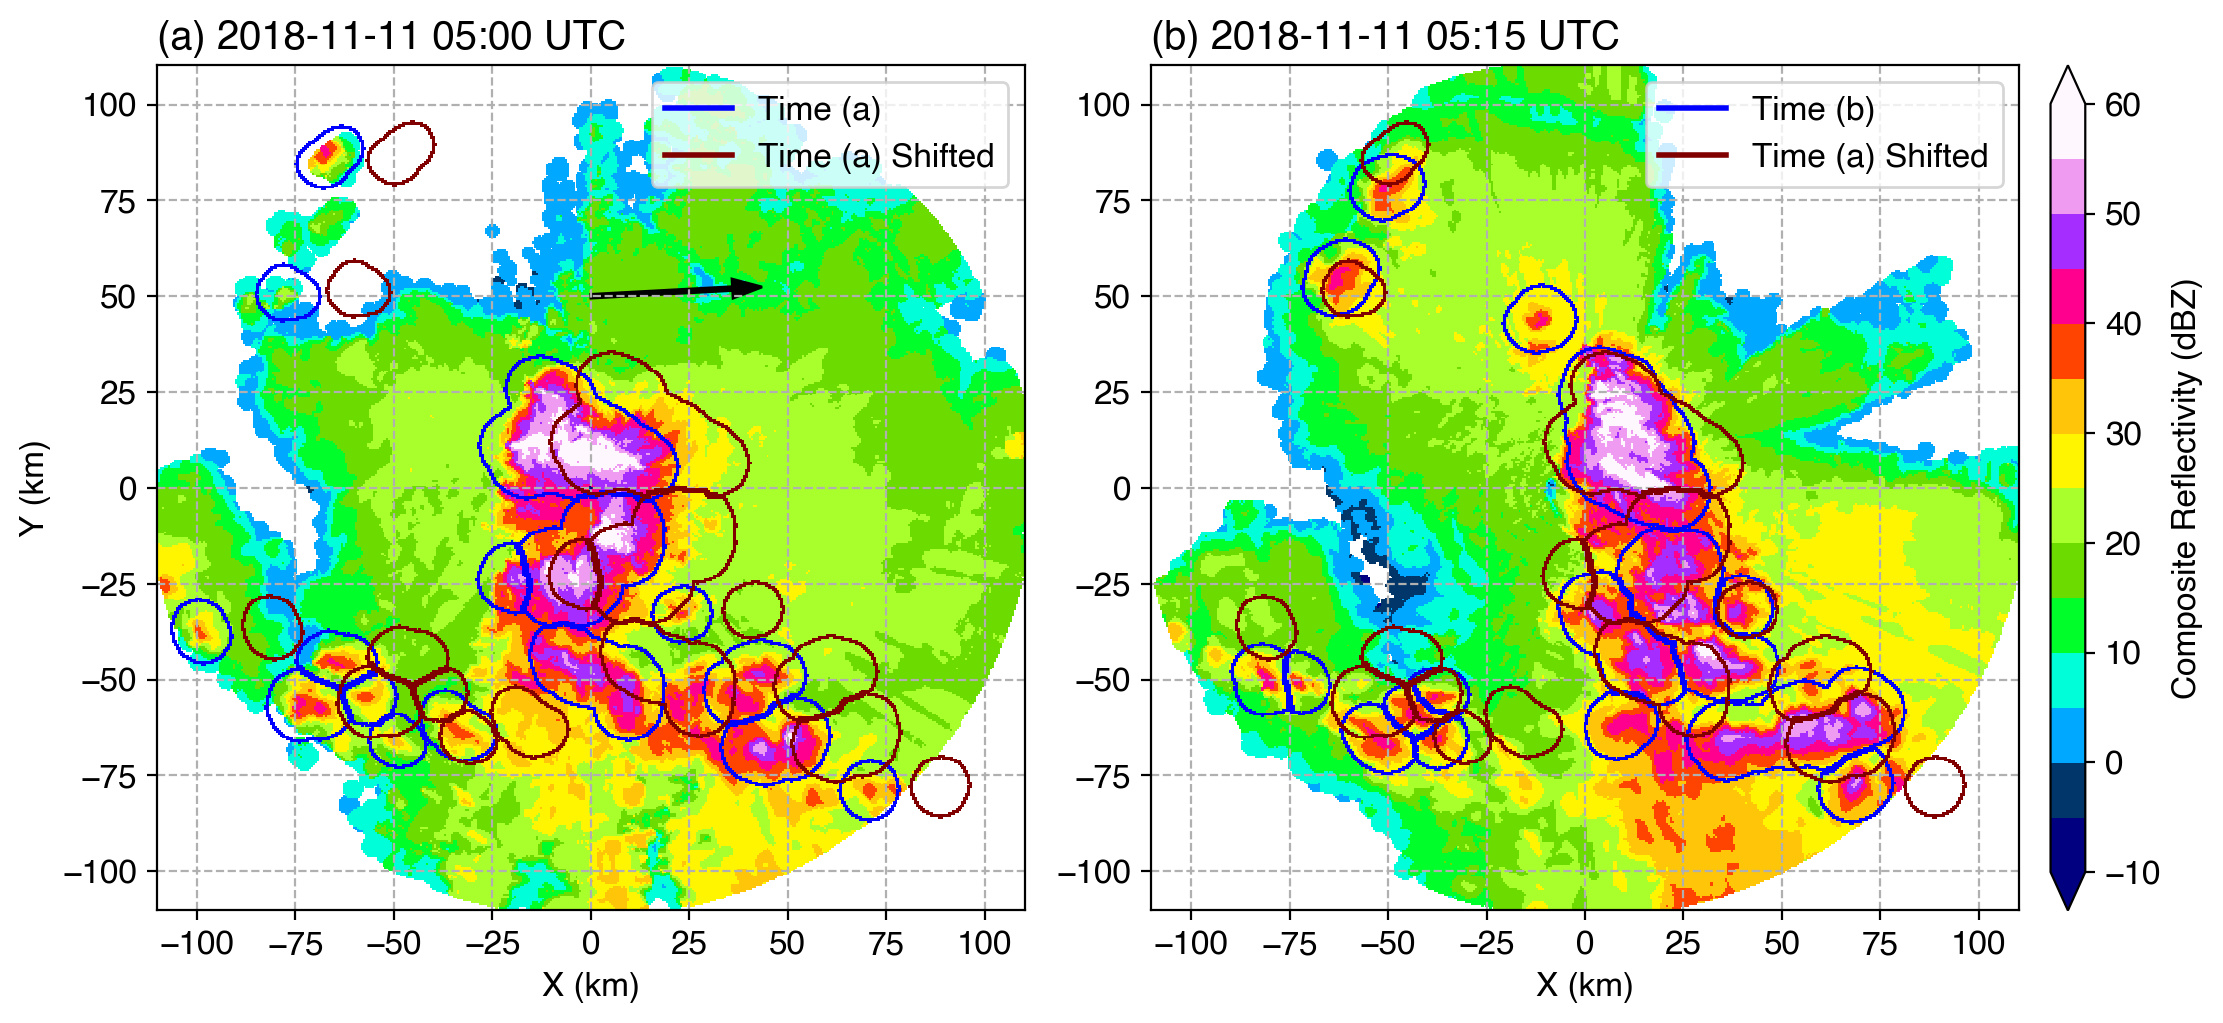

In [13]:
y_lag, x_lag = movement_of_storm_fft(dset_1, dset_2, varname=varname, figname=figname, plot_subplots=True, threshold=20)
mag_movement, mag_dir, mag_movement_mps = offset_to_speed(x_lag, y_lag, 15 * 60)
print(x_lag)
print(y_lag)
print(mag_movement)
print(mag_dir)
print(mag_movement_mps)

In [ ]:
figdir

In [ ]:
# field_1 = np.squeeze(dset_1['dbz_comp'].values)
# field_2 = np.squeeze(dset_2['dbz_comp'].values)
# xx = dset_1.x.values / 1000.
# yy = dset_1.y.values / 1000.

# timestr1 = dset_1.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
# timestr2 = dset_2.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
# fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
# timestr1, timestr2, fignametimestr

In [ ]:
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'Helvetica'

# fig = plt.figure(constrained_layout=True, figsize=[8,10], dpi=100)
# gs = fig.add_gridspec(3, 3, height_ratios=[1,1,1], width_ratios=[1,1,0.06])
# gs.update(right=0.8, wspace=0.06, hspace=0.05)

# ax1 = fig.add_subplot(gs[0, 0])
# pcm1 = ax1.pcolormesh(xx,yy, field_1, vmin=-10, vmax=60, cmap='gist_ncar')
# ax1.set_title('Time1', loc='left')
# ax1.set_ylabel('Y (km)')
# ax2 = fig.add_subplot(gs[0, 1])
# pcm2 = ax2.pcolormesh(xx,yy, field_2, vmin=-10, vmax=60, cmap='gist_ncar')
# ax2.set_title('Time2', loc='left')
# ax3 = fig.add_subplot(gs[1:, 0:2])
# pcm3 = ax3.pcolormesh(xx,yy, field_2, vmin=-10, vmax=60, cmap='gist_ncar')
# ax3.set_title('Time1,2', loc='left')
# ax3.set_xlabel('X (km)')
# ax3.set_ylabel('Y (km)')
# # Colorbar
# cb_ax = fig.add_subplot(gs[:,2])
# cbar = fig.colorbar(pcm1, cax=cb_ax, label='Reflectivity (dBZ)')